## Hill-curve neutralization

### Mathematical form of curves

The neutralization curve is fit to measurements of the fraction
infectivity remaining $f\left(c\right)$ at several different serum
concentrations $c$. The equation for the curve is:

$$
f(c) = b + \frac{t - b}{1 + (c/m)^s}
$$

where $m$ is the midpoint of the curve, $t$ is the “top” of
the curve, $b$ is the bottom of the curve, and $s$ is the
“slope” or Hill coefficient of the curve.

If the curve spans from completely non-neutralized (100% infectivity
remaining) to completely neutralized (0% infectivity remaining), then
$t = 1$ and $b = 0$. In this case, Equation (1) is
identical to 1 minus the [Hill equation defined on
Wikipedia](https://en.wikipedia.org/wiki/Hill_equation_(biochemistry)).

However, it will not always be the case that the top and bottom are at 1
and 0. The reason is that some antibodies and sera do not go to complete
neutralization (see
[here](https://doi.org/10.1371/journal.ppat.1005110) for a discussion
of the phenomenon for HIV). For such antibodies, $b$ will in
general be $>0$. Therefore, in the fitting you have the option of
constraining the top and bottom to $t = 1$ and $b = 0$, or
to fit them as free parameters.
The default is to constrain the top to
$t = 1$ and the bottom to $b = 0$, but you should look at your curves
to ensure this makes sense–and if they don’t plateau at complete neutralization,
set the bottom $b$ to be a free parameter to allow for incomplete neutralization.

Since $f\left(c\right)$ in Equation (1) is the fraction **infectivity**, we expect
$f\left(c\right)$ to get smaller as the antibody concentration
increases. Just be aware that some papers will plot fraction neutralized
rather than fraction infectivity; fraction neutralized is
$1 - f\left(c\right)$. If your data is fraction neutralized, you
should convert it to fraction infectivity before using this package.

### Fitting using the HillCurve class

The curves are fit using the `neutcurve.hillcurve.HillCurve`
class. For fitting to actual data, you will typically want to fit these
curves via `neutcurve.curvefits.CurveFits` as described in Fitting curves to real data, particularly when
there are multiple samples being fit at once. Nonetheless, here we
illustrate the basic fitting to a single sample using
`neutcurve.hillcurve.HillCurve`.

First, we import the requisite Python modules:

In [1]:
import pandas as pd

import neutcurve

Set pandas display options:

In [2]:
pd.set_option('display.float_format', '{:.5f}'.format)

Now we get example data to plot. We use as our example the
neutralization of wildtype (WT) A/WSN/1933 (H1N1) influenza by the
broadly neutralizing antibody FI6v3 as determined in [Fig 6a of Doud et
al (2018)](https://www.nature.com/articles/s41467-018-03665-3#Fig6).
The numerical data in that figure in tidy form are available in the CSV file
`example_data/Doud_et_al_2018-neutdata.csv`.
We read the data and get just the measurements for replicate 1 of
the wildtype virus against FI6v3:

In [3]:
fi6v3_datafile = 'example_data/Doud_et_al_2018-neutdata.csv'

<!-- Next cell sets right file path if running with pytest from top directory. -->

In [4]:
data = (pd.read_csv(fi6v3_datafile)
        .query('(serum == "FI6v3") & (virus == "WT") & (replicate == "1")')
        [['concentration', 'fraction infectivity']]
        .reset_index(drop=True)
        )
data.round(5)

,concentration,fraction infectivity
0,0.00020,1.01373
1,0.00048,0.94201
2,0.00112,0.99285
3,0.00260,0.96621
4,0.00607,0.95670
5,0.01417,0.58633
6,0.03305,0.16945
7,0.07712,0.01413
8,0.17995,-0.02539
9,0.41989,-0.03255


As can be seen above, the data give the fraction activity at each
antibody concentration (which in this case is in $\mu$g/ml).

Now we initialize a `neutcurve.hillcurve.HillCurve` with these
data:

In [5]:
curve = neutcurve.HillCurve(data['concentration'],
                            data['fraction infectivity'])

We can now look at the values of each of the four fit parameters that
define the curve:

In [6]:
print(f"The top (t) is {curve.top:.3g}\n"
      f"The bottom (b) is {curve.bottom:.3g}\n"
      f"The midpoint (m) is {curve.midpoint:.3g}\n"
      f"The slope (Hill coefficient)s is {curve.slope:.3g}")

The top (t) is 1
The bottom (b) is 0
The midpoint (m) is 0.0167
The slope (Hill coefficient)s is 2.5


Note that the top and bottom are one and zero as they were constrained
to those values.
If you want to change whether the top and/or bottom are
fixed or fit, you can do that using the  and 
arguments to `neutcurve.hillcurve.HillCurve` as described in
the docs for that class. For instance, below we fit the top and fix the
bottom (it makes very little difference for this particular dataset):

In [7]:
curve2 = neutcurve.HillCurve(data['concentration'],
                             data['fraction infectivity'],
                             fixtop=False)

print(f"The top (t) is {curve2.top:.3g}\n"
      f"The bottom (b) is {curve2.bottom:.3g}\n"
      f"The midpoint (m) is {curve2.midpoint:.3g}\n"
      f"The slope (Hill coefficient)s is {curve2.slope:.3g}")

The top (t) is 0.987
The bottom (b) is 0
The midpoint (m) is 0.0169
The slope (Hill coefficient)s is 2.57


We can also get the IC50, which is the concentration where
$f\left(c\right) = 0.5$. The IC50 will be equal to the midpoint
$m$ when the top ($t$) is one and the bottom ($b$) is
zero, but otherwise it may be different than the IC50. For this
particular dataset, the IC50 is very close to the midpoint:

In [8]:
print(f"The IC50 is {curve.ic50():.3g}")

The IC50 is 0.0167


Note that `neutcurve.hillcurve.HillCurve.ic50()` has a 
option for how to handle computing the IC50 if it doesn’t fall within
the range of the provided concentrations and so cannot be interpolated
(see the docs for that method for details). This doesn’t matter for this
particular dataset, however, since the IC50 falls within the range of
the data. There are also two other methods that deal with IC50s that
cannot be interpolated and so are only determinable as upper / lower
bounds:

> * `neutcurve.hillcurve.HillCurve.ic50_bound()`

> * `neutcurve.hillcurve.HillCurve.ic50_str()`

In [9]:
curve.ic50_bound()
curve.ic50_str()

'0.0167'

We can generalize the IC50 using `neutcurve.hillcurve.HillCurve.icXX()`,
which will compute the concentration at which an arbitrary fraction of
virus is expected to be **neutralized** (note that this is fraction neutralized,
which is one minus the fraction infectivity).
For instance:

In [10]:
print(f"The IC95 is {curve.icXX(0.95):.3g}")

The IC95 is 0.0541


Note that `neutcurve.hillcurve.HillCurve.icXX()` has a  argument
that determines how we handle the case when the ICXX is outside of the range
of measured concentrations, and that there are two other methods that deal
with ICXXs that cannot be interpolated and are only determinable as upper /
lower bounds:

> * `neutcurve.hillcurve.HillCurve.icXX_bound()`

> * `neutcurve.hillcurve.HillCurve.icXX_str()`

We can plot the neutralization curve using the
`neutcurve.hillcurve.HillCurve.plot()` function. This returns a
matplotlib figure and axis instance:

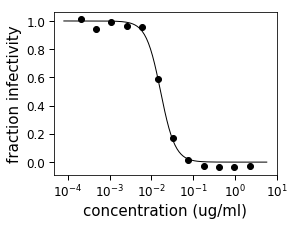

In [11]:
fig, ax = curve.plot(xlabel='concentration (ug/ml)')

If you want to save the figure, do this using its
[savefig](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.savefig.html)
method, possibly calling
[tight_layout](https://matplotlib.org/users/tight_layout_guide.html)
command first if there is clipping.